In [1]:
import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from tensorboardX import SummaryWriter

# TensorBoard

In [2]:
from tensorboardX import SummaryWriter
#SummaryWriter encapsulates everything
writer = SummaryWriter('../experiment-logs/a2c-simple-env')

# utils

In [3]:
from collections import OrderedDict
import numpy as np
import torch
import gymnasium as gym
from typing import Dict, Tuple, List

############################################
############################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def sample_trajectory(
    env: gym.Env, agent, max_length: int) -> Dict[str, np.ndarray]:
    """Sample a rollout in the environment from a policy."""
    ob, info = env.reset()
    obs, acs, rewards, next_obs, terminals = [], [], [], [], []
    steps = 0
    while True:
        action = agent.get_action(ob)

        next_ob, reward, terminated, truncated, info = env.step(action)

        steps += 1
        done: bool = (terminated or truncated or steps >= max_length)

        obs.append(ob)
        acs.append(action)
        rewards.append(reward)
        next_obs.append(next_ob)
        terminals.append(done)

        ob = next_ob 

        if done:
            break

    return {
        "observation": np.array(obs, dtype=np.float32),
        "reward": np.array(rewards, dtype=np.float32),
        "action": np.array(acs, dtype=np.float32),
        "next_observation": np.array(next_obs, dtype=np.float32),
        "terminal": np.array(terminals, dtype=np.float32),
    }

def sample_trajectories(
    env: gym.Env,
    agent,
    min_timesteps_per_batch: int,
    max_length: int
) -> Tuple[List[Dict[str, np.ndarray]], int]:
    """Collect rollouts using policy until we have collected min_timesteps_per_batch steps."""
    timesteps_this_batch = 0
    trajs = []
    while timesteps_this_batch < min_timesteps_per_batch:
        # collect rollout
        traj = sample_trajectory(env, agent, max_length)
        trajs.append(traj)

        # count steps
        timesteps_this_batch += get_traj_length(traj)
    return trajs, timesteps_this_batch

def sample_n_trajectories(
    env: gym.Env, agent, ntraj: int, max_length: int):
    """Collect ntraj rollouts."""
    trajs = []
    for _ in range(ntraj):
        # collect rollout
        traj = sample_trajectory(env, agent, max_length)
        trajs.append(traj)
    return trajs

def convert_listofrollouts(trajs):
    """
    Take a list of rollout dictionaries and return separate arrays, where each array is a concatenation of that array
    from across the rollouts.
    """
    observations = np.concatenate([traj["observation"] for traj in trajs])
    actions = np.concatenate([traj["action"] for traj in trajs])
    next_observations = np.concatenate([traj["next_observation"] for traj in trajs])
    terminals = np.concatenate([traj["terminal"] for traj in trajs])
    concatenated_rewards = np.concatenate([traj["reward"] for traj in trajs])
    unconcatenated_rewards = [traj["reward"] for traj in trajs]
    return (
        observations,
        actions,
        next_observations,
        terminals,
        concatenated_rewards,
        unconcatenated_rewards,
    )

def get_traj_length(traj):
    return len(traj["reward"])

def from_numpy(*args, **kwargs):
    return torch.from_numpy(*args, **kwargs).float().to(device)

def to_numpy(tensor: torch.Tensor):
    return tensor.to('cpu').detach().numpy()

# 把 Agent 的定义放在这里

In [4]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class PolicyNet(nn.Module):
    def __init__(self, obs_dim, ac_dim):
        super().__init__()
        hidden_dim = 128
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim), 
            nn.LeakyReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.LeakyReLU(), 
            nn.Linear(hidden_dim, ac_dim)
        )

    def forward(self, x):
        assert isinstance(x, torch.Tensor), f"Input must be a tensor!"
        assert len(x.shape) > 1, f"Input must be batched!"
        return F.softmax(self.net(x), dim=-1)

class ValueNet(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        hidden_dim = 128
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        assert isinstance(x, torch.Tensor), f"Input must be a tensor!"
        assert len(x.shape) > 1, f"Input must be batched!"
        return self.net(x)
    
class A2CAgent:
    def __init__(self, env: gym.Env, discounted_factor: float=0.95, 
                 actor_lr: float=1e-4, critic_lr: float=1e-4):
        """
        Action space should be discrete.
        """
        self.env = env
        self.discounted_factor = discounted_factor

        action_dim = self.env.action_space.n
        if isinstance(self.env.observation_space, gym.spaces.Discrete):
            obs_dim = np.int64(1)
        elif isinstance(self.env.observation_space, gym.spaces.Box):
            obs_dim = self.env.observation_space.shape[0]
        self.actor = PolicyNet(obs_dim, action_dim)
        self.critic = ValueNet(obs_dim)
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        
    def get_action(self, obs, is_training=True):
        assert isinstance(obs, np.ndarray), f"Input must be an ndarray, but get obs: {obs}"
        obs = from_numpy(obs)
        obs = torch.unsqueeze(obs, dim=0)
        action_dists =  self.actor(obs).squeeze(0)
        if is_training:
            action = torch.multinomial(action_dists, num_samples=1)[0]
        else:
            action = torch.argmax(action_dists)
        action = to_numpy(action)

        assert action in self.env.action_space, f"Returned action {action} not in action space!"
        return action

    def update(self, observations, actions, rewards, terminates, next_observations) -> tuple[float, float]:
        """
        Input must be batched numpy arrays.
        """
        observations = from_numpy(observations)
        actions = from_numpy(actions)
        rewards = from_numpy(rewards)
        terminates = from_numpy(terminates)
        next_observations = from_numpy(next_observations)
        actions = actions.to(dtype=torch.int64)
        
        # update critic
        with torch.no_grad():
            td_targets =  rewards + self.discounted_factor * (1 - terminates) * self.critic(next_observations)
            td_errors = td_targets - self.critic(observations)

        critic_loss = F.mse_loss(self.critic(observations), td_targets.detach())

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # update actor
        actions_dists = self.actor(observations)
        actions_probs = actions_dists.gather(1, actions.unsqueeze(-1)).squeeze(-1)
        actions_log_probs = torch.log(actions_probs + 1e-10).reshape((-1, 1))
        actor_loss = (-td_errors.detach() * actions_log_probs).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        return critic_loss.item(), actor_loss.item()

# 实验

In [5]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces

class OneDimensionalEnv(gym.Env):
    def __init__(self):
        super().__init__()
        
        # action sapce: 0代表+0.1, 1代表+1, 2代表-1, 3代表-0.1
        self.action_space = spaces.Discrete(4)
        
        # obs space: 一维连续空间,范围(-5,5)
        self.observation_space = spaces.Box(
            low=-5.0, high=5.0, shape=(1,), dtype=np.float32
        )
        
        self.state = None
        
    def reset(self, seed=None):
        super().reset(seed=seed)
        
        # 随机初始化位置，但不在(-1,1)内
        position = np.random.uniform(-5, 5)
        while -1 < position < 1:
            position = np.random.uniform(-5, 5)
        self.state = np.array([position], dtype=np.float32)
        
        return self.state, {}
    
    def step(self, action):
        assert self.action_space.contains(action)
        
        # 0代表+0.1, 1代表+1, 2代表-1, 3代表-0.1
        match action:
            case 0:
                self.state[0] += 0.1
            case 1:
                self.state[0] += 1.0
            case 2:
                self.state[0] -= 1.0
            case 3:
                self.state[0] -= 0.1
            
        done = False
        reward = 0
        
        # 超出范围或者进入计分区域则结束
        if self.state[0] < -5 or self.state[0] > 5:
            done = True
            reward = -5
        elif -1 < self.state[0] < 1:
            done = True
            reward = 1 - abs(self.state[0])
            
        return self.state, reward, done, False, {}
    
    def render(self):
        print(f"Current position: {self.state[0]:.2f}")

In [6]:
# 8个观测值：包括x/y坐标、速度、角度、角速度和两个腿的接触状态
# 4个离散动作：无动作、左引擎、主引擎、右引擎
env = gym.make("LunarLander-v3")
# simpler env
env = gym.make("CartPole-v1")

In [7]:

# simpler simpler
env  = OneDimensionalEnv()
agent = A2CAgent(env, actor_lr=1e-4, critic_lr=1e-3)

In [11]:
total_episodes = 1000
traj_per_batch = 20
scores = []
training_actor_loss = []
training_critic_loss = []

for episode in tqdm(range(1, total_episodes + 1)):
    trajs = sample_n_trajectories(env, agent, ntraj=traj_per_batch, max_length=10000)
    observations, actions, next_observations, terminals, rewards, _ = convert_listofrollouts(trajs)
    rewards = rewards.reshape(-1, 1)
    terminals = terminals.reshape(-1, 1)
    critic_loss, actor_loss = agent.update(observations, actions, rewards, terminals, next_observations)

    writer.add_scalar('score', np.sum(rewards) / traj_per_batch, episode)
    writer.add_scalar('actor_loss', actor_loss, episode)
    writer.add_scalar('critic_loss', critic_loss, episode)
    

100%|██████████| 1000/1000 [00:37<00:00, 26.61it/s]


# 可视化value hat

In [12]:
value_hat = list(agent.critic(torch.range(-4, 4, 0.2).unsqueeze(1)).squeeze(1))
value_hat = [value.item() for value in value_hat]

C:\Users\Rinevard\AppData\Local\Temp\ipykernel_19252\561150996.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  value_hat = list(agent.critic(torch.range(-4, 4, 0.2).unsqueeze(1)).squeeze(1))


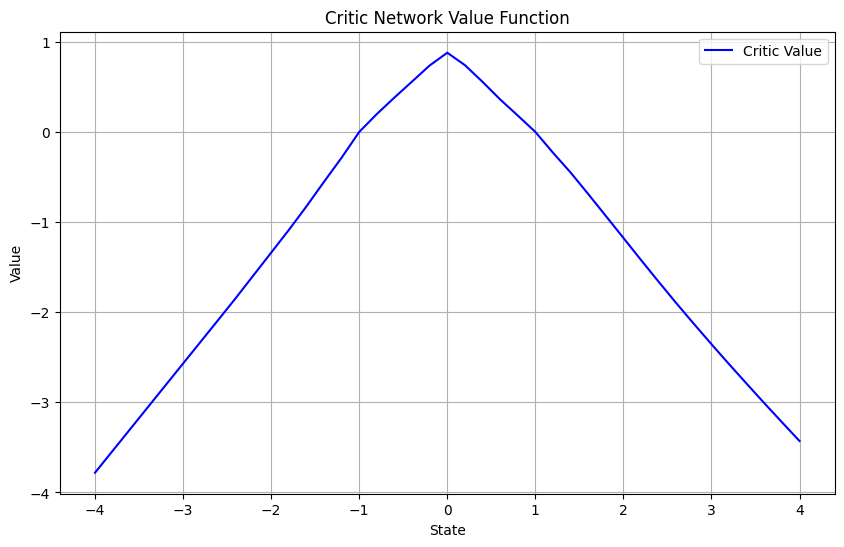

In [13]:
# 创建图表
fig = plt.figure(figsize=(10, 6))
x = np.arange(-4, 4.2, 0.2)
plt.plot(x, value_hat, 'b-', label='Critic Value')
plt.grid(True)
plt.xlabel('State')
plt.ylabel('Value')
plt.title('Critic Network Value Function')
plt.legend()
plt.show()

# 添加到 TensorBoard
writer.add_figure('Critic Value Function', fig, global_step=0)
writer.close()